# DandeLiion API - PyBaMM comparison

In [1]:
import dandeliion.client as dandeliion
import numpy as np
import matplotlib.pyplot as plt
import pybamm
from pybamm import Experiment

# The following lines enable logging output in this notebook
import sys
import logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

In [2]:
dandeliion.__version__

'1.0.0rc2'

### Authentication
Define the simulator object by providing the API URL and API token:

In [16]:
api_url = "https://api.dandeliion.com/v1"
api_key = "f1543b9ff2001d04bd2c002d9375c8a28ad0bcac9914ce5d8f0e0b98ef4404cfa"
simulator = dandeliion.Simulator(api_url, api_key)

### Battery parameters
Can be a valid BPX file name/path or already read-in valid BPX as a `dict` or `BPX` object itself:

In [4]:
# params = '2025-04-10-parameters_Dandeliion_example.json'
params = 'examples/AE_gen1_BPX.json'

### Experiment
PyBaMM `Experiment` object, for example:

In [5]:
experiment = Experiment(
  [
      "Discharge at C/2 for 10 hours or until 2.5 V"  # Discharging at 1C crashes PyBaMM
  ],
  period = "10 s",
)

### Additional model/backend-specific parameters
Define a dictionary of extra parameters outside the BPX standard, such as mesh, initial state of charge or voltage, etc.:

In [6]:
extra_params = {}

is_isothermal = True

# Number of mesh points in PyBaMM format (default is 16 mesh points everywhere):
extra_params['Mesh'] = {"x_n": 32, "x_s": 16, "x_p": 32, "r_n": 32, "r_p": 32}

# Initial state of charge (default is 1):
extra_params['Initial SOC'] = 1.0

### Start the simulation in the cloud

In [17]:
solution = dandeliion.solve(
    simulator=simulator,
    params=params,
    experiment=experiment,      # optional (1C discharge for 1 hour or until the `Lower voltage cut-off [V]` from BPX will be used by default)
    extra_params=extra_params,  # optional (initial conditions from the BPX, fully charged state, and single cell Newman model with constant temperature will be used by default)
    is_blocking=True            # optional (`True` by default)
)

print("Solution status:", solution.status)

DandeliionAPIException: Your request has failed: Forbidden

### Start PyBaMM simulation with the same parameters

In [8]:
print(f"\nPyBaMM {pybamm.__version__} simulation...\n")

pybamm_params = pybamm.ParameterValues.create_from_bpx(params)

if is_isothermal:
    model = pybamm.lithium_ion.DFN()

else:
    pybamm_params.update(
        {
            "Total heat transfer coefficient [W.m-2.K-1]": 0.0,
        },
        check_already_exists=False,
    )

    model_opts = {"thermal": "lumped", "cell geometry": "arbitrary"}

    model = pybamm.lithium_ion.DFN(options=model_opts)

# Sim object
sim = pybamm.Simulation(
    model,
    parameter_values=pybamm_params,
    experiment=experiment,
    var_pts=extra_params['Mesh'],
)

sol = sim.solve()

t_eval = np.arange(0, 10 * 3600, 10)

# PyBaMM outputs
t = sol["Time [s]"](t=t_eval)
I = sol["Current [A]"](t=t_eval)
V = sol["Voltage [V]"](t=t_eval)
T = sol["Volume-averaged cell temperature [K]"](t=t_eval)
x = sol["x [m]"](t=t_eval)
ce = sol["Electrolyte concentration [mol.m-3]"](t=t_eval)


PyBaMM 25.1.1 simulation...



/home/schewtsj/Documents/dandeliion/dandeliion-client/.venv/lib/python3.12/site-packages/pybamm/parameters/parameter_values.py:163: UserWarning: 'Open-circuit voltage at 0% SOC [V]' not found in BPX file. Using 'Lower voltage cut-off [V]'.
  return ParameterValues._create_from_bpx(bpx, target_soc)
/home/schewtsj/Documents/dandeliion/dandeliion-client/.venv/lib/python3.12/site-packages/pybamm/parameters/parameter_values.py:163: UserWarning: 'Open-circuit voltage at 100% SOC [V]' not found in BPX file. Using 'Upper voltage cut-off [V]'.
  return ParameterValues._create_from_bpx(bpx, target_soc)


In [9]:
t_eval = np.arange(0, 10 * 3600, 10)

# PyBaMM outputs
print(sol["Time [s]"](t=t_eval))


solution.status

[ 0. 10. 20. ... nan nan nan]


'success'

### Accessing the log file 

In [10]:
print(solution.log)

[2025-05-13 13:33:14.726] [info] Starting dandeliion-models v0.1.1...
[2025-05-13 13:33:14.726] [info] Parsing input JSON file parameters.json...
[2025-05-13 13:33:14.727] [info] Input JSON file parsing time: 0.103 ms
[2025-05-13 13:33:14.727] [info] Initialising simulation parameters...
[2025-05-13 13:33:14.727] [info] Title: About:Energy Gen1 Demo 21700 NMC811|graphite 5 Ah cell
[2025-05-13 13:33:14.727] [info] Model: DFN
[2025-05-13 13:33:14.732] [info] Thermal model: Isothermal
[2025-05-13 13:33:14.732] [info] Found DandeLiion Experiment...
[2025-05-13 13:33:14.732] [info] Number of instructions to parse: 1
[2025-05-13 13:33:14.732] [info] Solver mode: Fast (default)
[2025-05-13 13:33:14.733] [info] Simulation parameters initialisation time: 5.953 ms
[2025-05-13 13:33:14.733] [info] Starting the simulation...
[2025-05-13 13:33:14.733] [info] Computational mesh: 31x31 + 15 + 31x31 finite volumes
[2025-05-13 13:33:14.733] [info] Total number of equations: 2204
[2025-05-13 13:33:14.73

### Results
Print all available keys in the solution object.
Here method `keys()` is used to get all available keys in the solution object.

In [11]:
for key in sorted(solution.keys()):
    print(key)

Current [A]
Electrolyte concentration [mol.m-3]
Electrolyte potential [V]
Electrolyte x-coordinate [m]
Temperature [K]
Time [s]
Voltage [V]
X-averaged negative electrode exchange current density [A.m-2]
X-averaged negative electrode potential [V]
X-averaged negative electrode surface concentration [mol.m-3]
X-averaged positive electrode exchange current density [A.m-2]
X-averaged positive electrode potential [V]
X-averaged positive electrode surface concentration [mol.m-3]


In [12]:
def last_non_nan(arr):
    """
    A helper function to get the last non-NaN element in an array and its index.
    """
    for idx, element in enumerate(arr[::-1]):
        if not np.isnan(element):
            return element, len(arr) - 1 - idx
    return None, None  # Return None, None if all elements are NaN

t_last, i_last = last_non_nan(t)

# Print the final values of time, voltage, and temperature
print(f"Final PyBaMM | DandeLiion time [s]: {t_last} | {solution['Time [s]'][-1]}")
print(f"Final PyBaMM | DandeLiion voltage [V]: {V[i_last]} | {solution['Voltage [V]'][-1]}")
print(f"Final PyBaMM | DandeLiion temperature [K]: {T[i_last]} | {solution['Temperature [K]'][-1]}")

INFO:dandeliion.client.solution:Fetching 'Time [s]' column from simulator
Final PyBaMM | DandeLiion time [s]: 7070.0 | 7072.736010742187
INFO:dandeliion.client.solution:Fetching 'Voltage [V]' column from simulator
Final PyBaMM | DandeLiion voltage [V]: 2.5413060688743845 | 2.500000590706157
INFO:dandeliion.client.solution:Fetching 'Temperature [K]' column from simulator
Final PyBaMM | DandeLiion temperature [K]: 298.15 | 298.15


INFO:dandeliion.client.solution:Fetching 'Current [A]' column from simulator


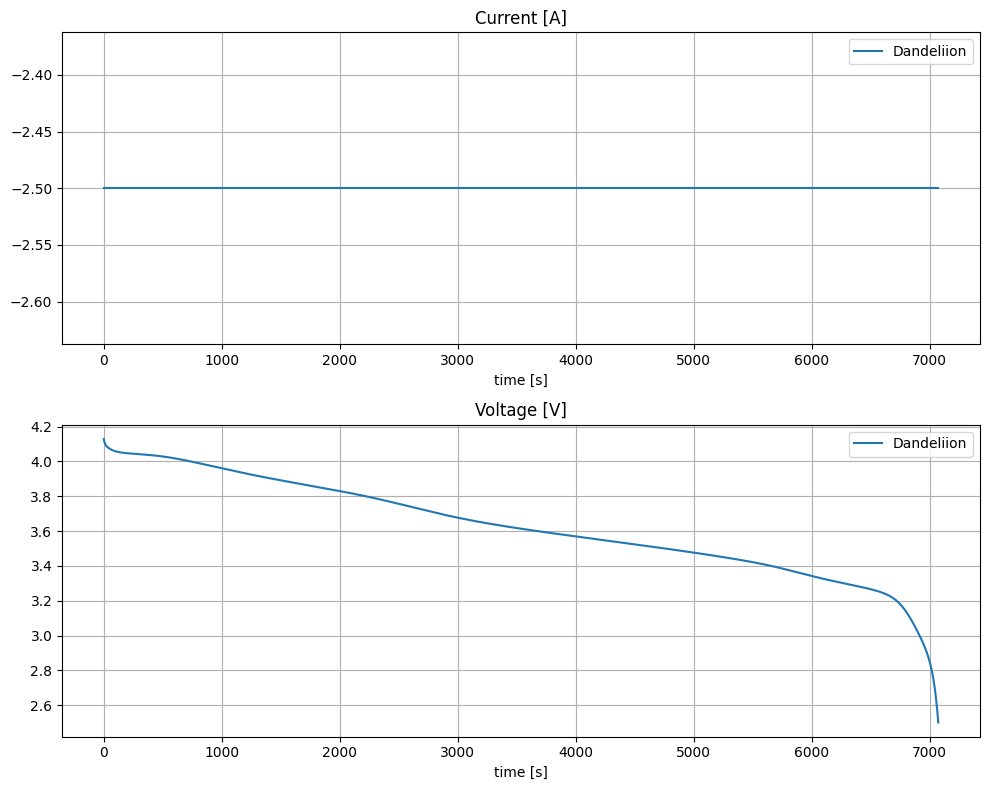

In [13]:
# Plot current and voltage vs time.
# Here we access scalar values vs time.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(solution["Time [s]"], solution["Current [A]"], label="Dandeliion")
axs[0].set_xlabel("time [s]")
axs[0].set_title("Current [A]")
axs[0].legend()
axs[0].grid()
axs[1].plot(solution["Time [s]"], solution["Voltage [V]"], label="Dandeliion")
axs[1].set_xlabel("time [s]")
axs[1].set_title("Voltage [V]")
axs[1].legend()
axs[1].grid()
plt.tight_layout()
plt.show()

INFO:dandeliion.client.solution:Fetching 'Electrolyte x-coordinate [m]' column from simulator
INFO:dandeliion.client.solution:Fetching 'Electrolyte concentration [mol.m-3]' column from simulator


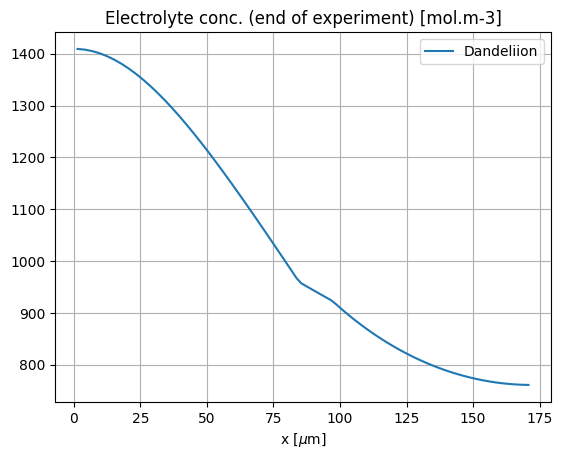

In [14]:
# Concentration in the electrolyte vs `x` at the last time step.
# Here we access spatially dependent values vs time.
plt.plot(
    solution["Electrolyte x-coordinate [m]"] * 1e6,
    solution["Electrolyte concentration [mol.m-3]"][-1],
    label="Dandeliion",
)
plt.xlabel(r"x [$\mu$m]")
plt.title("Electrolyte conc. (end of experiment) [mol.m-3]")
plt.legend()
plt.grid()
plt.show()

In [15]:
# A list of output times (optional)
t_eval = np.arange(0, 20, 1)

# If the user needs the solution at the `t_eval` times, the following code can be used (works only correctly on columns with timeline data).
# This is a linear interpolation with constant extrapolation:
print("Time [s]\tVoltage [V]")
for t, voltage in zip(t_eval, solution["Voltage [V]"](t=t_eval)):
    print(f"{t}\t{voltage}")


Time [s]	Voltage [V]
0	4.129041341547117
1	4.124194442602347
2	4.120520383950178
3	4.117363889833689
4	4.115039941397865
5	4.112808498037672
6	4.110577054677479
7	4.108714902570646
8	4.107011018143824
9	4.105307133717003
10	4.10360324929018
11	4.101899364863359
12	4.100195480436537
13	4.098655870508287
14	4.097499567743369
15	4.09634326497845
16	4.095186962213532
17	4.094030659448613
18	4.092874356683695
19	4.091718053918777
